In [15]:
import numpy as np
import matplotlib.pyplot as plt

from pyPhaseLabel import PhaseModel, CrystalPhase, EQ, BackgroundModel, FixedPseudoVoigt
from pyPhaseLabel import create_phases, evaluate_obj, optimize_phase, Lorentz, PseudoVoigt
from julia.Main import Wildcard, Lazytree, search, get_probabilities, get_fraction

## Create phase objects

In [2]:
with open('sticks.csv', 'r') as f:
    t = f.read()

phases = create_phases(t, 0.1, PseudoVoigt(0.5)) # PseudoVoigt has a degree of freedom in peak shape
for idx, phase in enumerate(phases):
    print(idx, phase.name)

0 TaO2_P42/mnm
1 PbTa4O11_R3H
2 TaO_Fm-3m
3 Pb1.49Ta2O6.28_Fd-3mZ
4 Ta2O5_P2mm
5 TaO2_I41/aZ
6 Pb2(Ta1.404Pb0.598)O6.21_Fd-3mZ
7 Ta2O5_Cmmm
8 Ta2O5_C121


## Evaluating objects

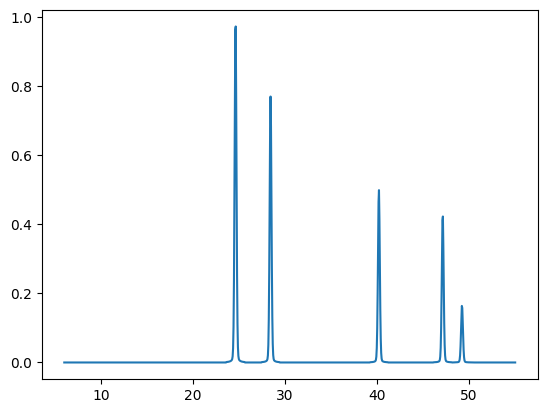

In [3]:
x = np.linspace(6, 55, 1024)
y = np.zeros(1024)
new_phase = CrystalPhase(phases[2], [4.5, 1.0, 0.15, 0.4]) # This modifies the lattice parameters of this cubic phase
t = evaluate_obj(phases[2], x)
plt.plot(x, t)

In [8]:
test_data = (evaluate_obj(new_phase, x)
             + 0.2*np.sin(x/10)
             + 0.1*np.random.randn(1024)+0.2)
bg = BackgroundModel(x, EQ(), 20, 100) # q vector, kernel function, 
p = PhaseModel(phases[2], bg)

std_noise = 0.05
mean = [1., .5, .2] # lattice, activation, width
std = [0.05, 0.05, 0.05] # 

pm, uncer = optimize_phase(p, x, test_data, std_noise, mean, std, maxiter=512, optimize_mode="WithUncer", verbose=True)
print(f"uncer: {uncer}")

iteration 1:
		residual norm = 139.3099985525045,
		maximum residual = 19.84817814124722,
		λ = 142.85714285714286,
		improvement = 0.12073826849351121
iteration 2:
		residual norm = 139.2256371336811,
		maximum residual = 19.840620988924577,
		λ = 204.08163265306123,
		improvement = 0.08436141882341985
iteration 3:
		residual norm = 139.16664675433645,
		maximum residual = 19.835346001120058,
		λ = 291.5451895043732,
		improvement = 0.05899037934463536
iteration 4:
		residual norm = 139.12538258726084,
		maximum residual = 19.831659846719678,
		λ = 416.49312786339027,
		improvement = 0.0412641670756102
iteration 5:
		residual norm = 139.09651113089527,
		maximum residual = 19.829082320421815,
		λ = 594.9901826619861,
		improvement = 0.02887145636557875
iteration 6:
		residual norm = 139.07630749380766,
		maximum residual = 19.82727930979759,
		λ = 849.9859752314087,
		improvement = 0.02020363708760442
iteration 7:
		residual norm = 138.93469874169668,
		maximum residual = 19.814480118

In [9]:
print(f"uncer: {np.sqrt(uncer)}")

uncer: [0.00011967 0.00011967 0.00011967 0.         0.         0.
 0.02030393 0.02125854]


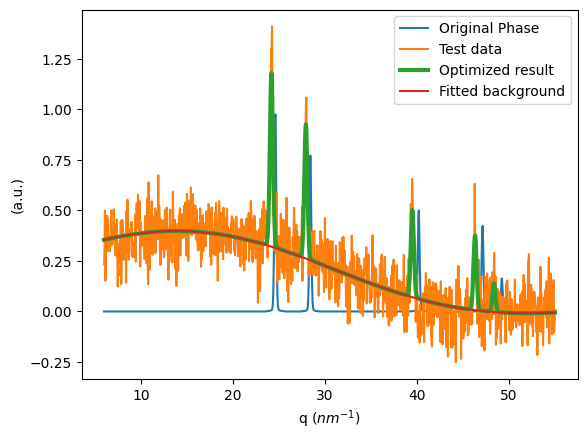

In [10]:
plt.plot(x, t, label="Original Phase")
plt.plot(x, test_data, label="Test data")
plt.plot(x, evaluate_obj(pm, x), label="Optimized result", linewidth=3)
plt.plot(x, evaluate_obj(pm.background, x), label="Fitted background")
plt.legend()
plt.xlabel("q ($nm^{-1}$)")
plt.ylabel("(a.u.)")
plt.show()

In [33]:
with open('sticks.csv', 'r') as f:
    t = f.read()
tt = t.split("#\n")
tt.remove("")

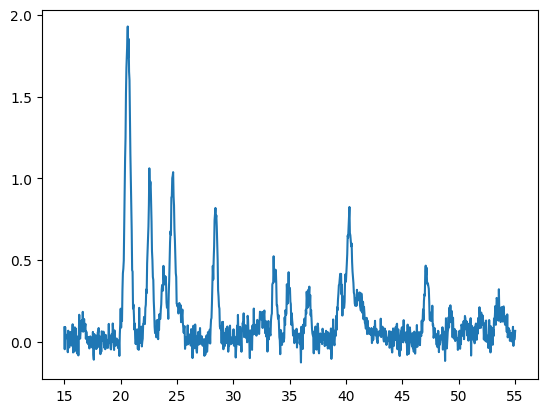

In [34]:
phases = create_phases(t, .2, FixedPseudoVoigt(0.1))
x = np.linspace(15, 55, 1024)

tree = Lazytree(phases[:4], x)

y = evaluate_obj(phases[1:4], x)+ 0.05*np.random.randn(1024)
plt.plot(x, y)
plt.show()

In [29]:
result = search(tree, x, y, 3, 3, .1, False, False, 0.5,
                std_noise, mean, std, optimize_mode="EM",
                maxiter=128, regularization=True)

In [35]:
results = [r for subresults in result[1:] for r in subresults]
probs = get_probabilities(results, x, y, std_noise, mean, std)
ind = np.argmax(probs)
print(get_fraction(results[ind].phase_model.CPs))

[0.56596073 0.16371373 0.27032554]


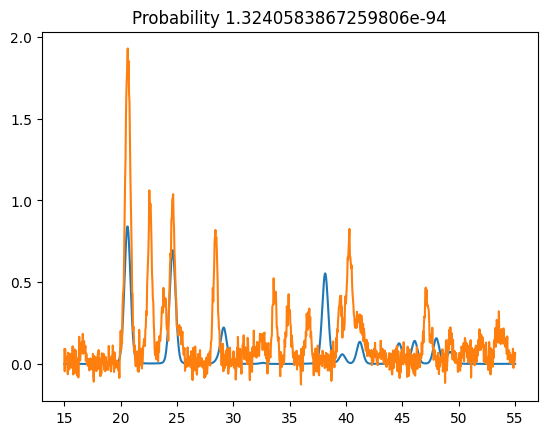

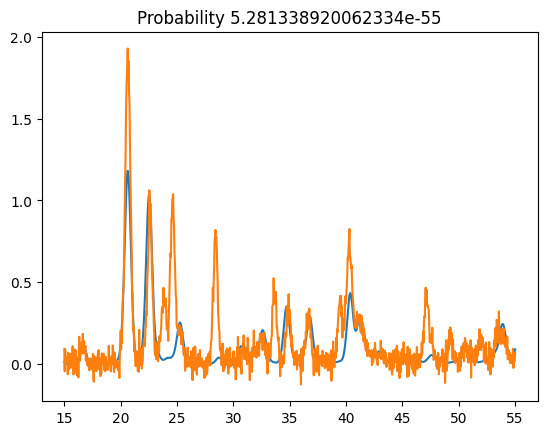

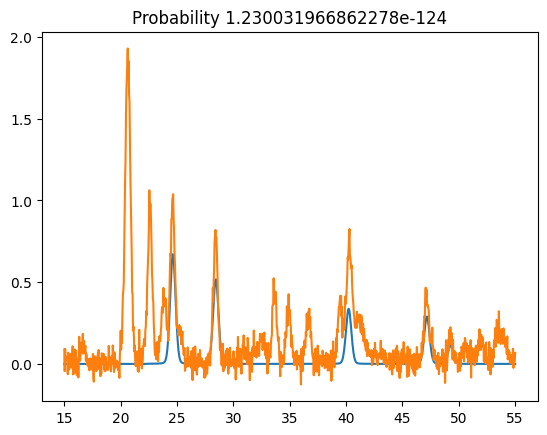

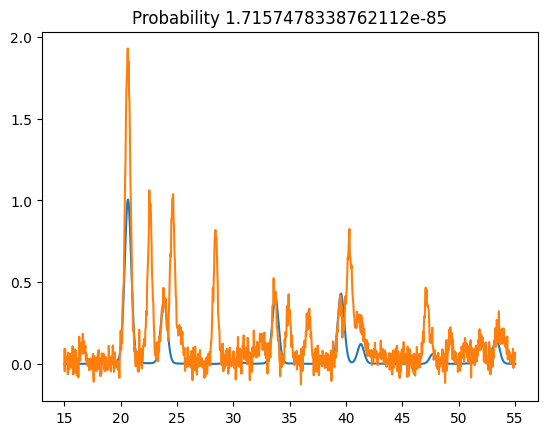

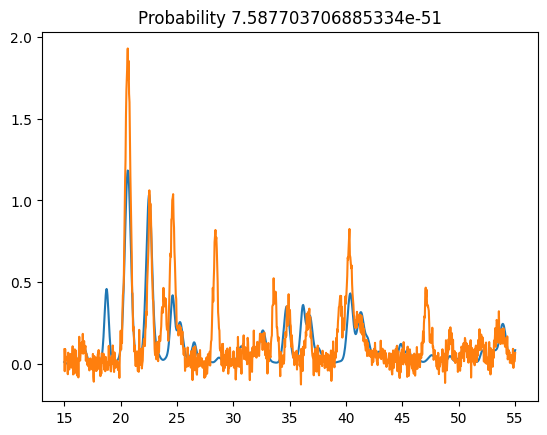

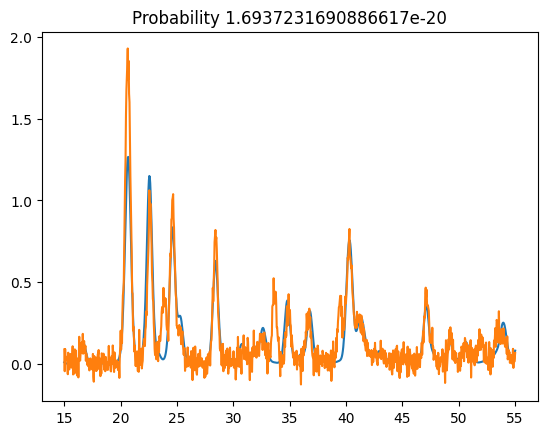

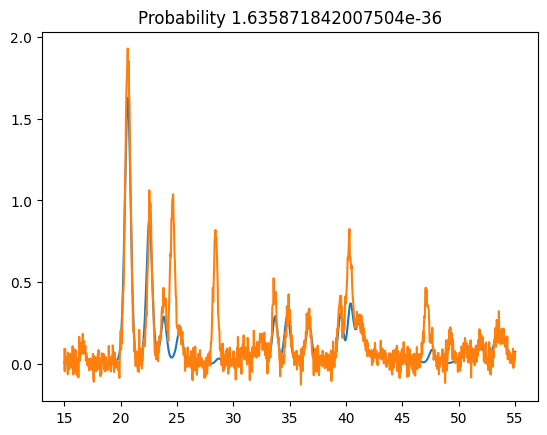

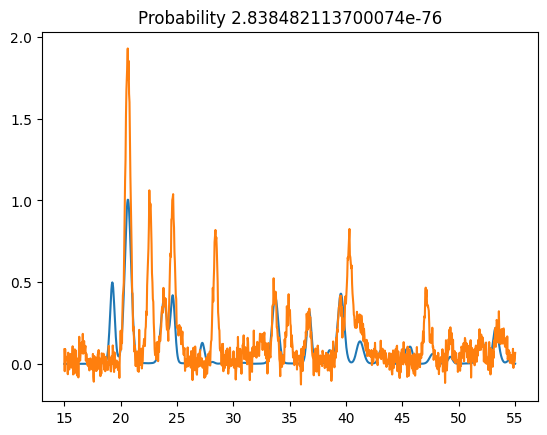

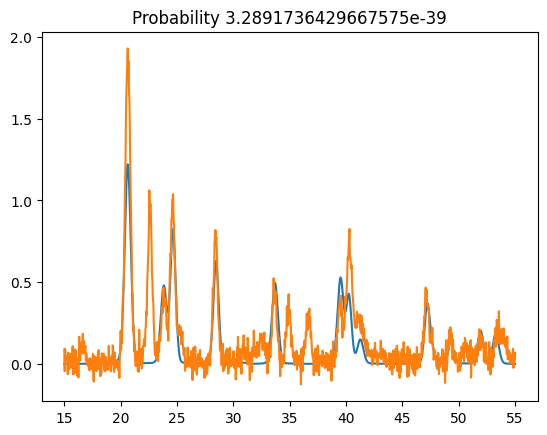

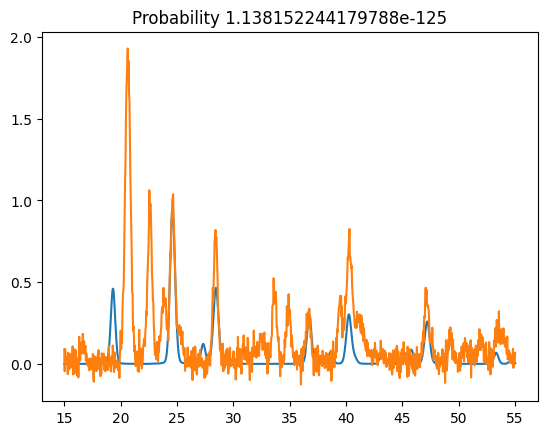

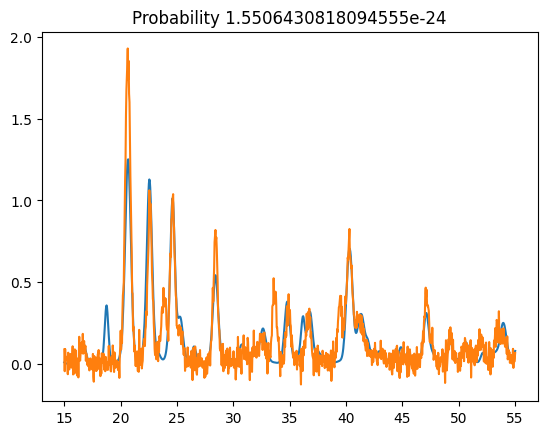

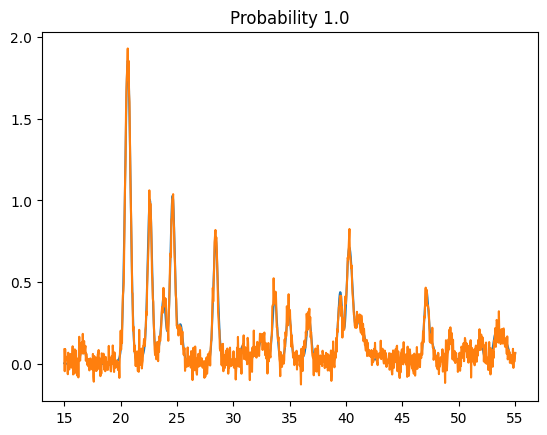

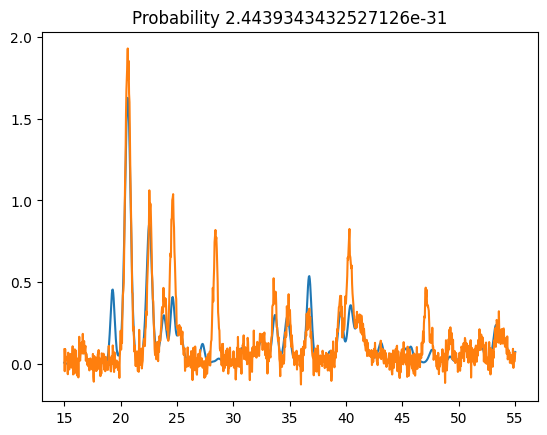

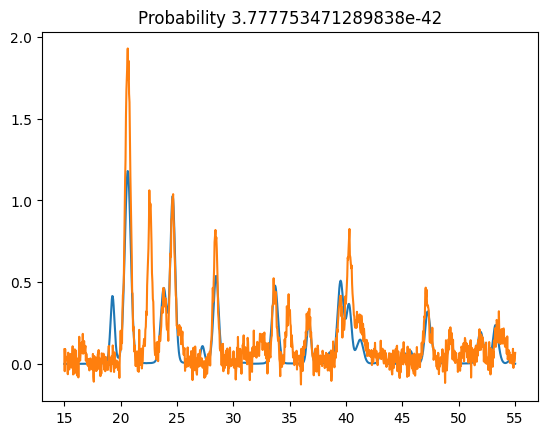

In [37]:
for idx, node in enumerate(results):
   # a = [np.linalg.norm(evaluate_obj(n.phase_model, x)-y) for n in node]
   # ind = np.argmin(a)
   plt.plot(x, evaluate_obj(node.phase_model, x))
   plt.plot(x, y)
   plt.title(f"Probability {probs[idx]}")
   plt.show()